In [1]:
import os
import torch
import pandas as pd
import numpy as np
import seaborn as sns
from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from sklearn.metrics import f1_score
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Exploring the sport image dataset

In [2]:
labels = {
    0: 'badminton',
    1: 'baseball',
    2: 'basketball',
    3: 'boxing',
    4: 'chess',
    5: 'cricket',
    6: 'fencing',
    7: 'football',
    8: 'formula1',
    9: 'gymnastics',
    10: 'hockey',
    11: 'ice_hockey',
    12: 'kabaddi',
    13: 'motogp',
    14: 'shooting',
    15: 'swimming',
    16: 'table_tennis',
    17: 'tennis',
    18: 'volleyball',
    19: 'weight_lifting',
    20: 'wrestling',
    21: 'wwe'
}

In [3]:
DATA_DIR ='/content/drive/MyDrive/input/data'
DATA_CSV = '/content/drive/MyDrive/input/data.csv'

In [4]:
!head "{DATA_CSV}"

image_path,target
../input/data/gymnastics/00000774.jpg,9.0
../input/data/table_tennis/00000702.jpg,16.0
../input/data/fencing/00000275.jpg,6.0
../input/data/baseball/00000380.jpg,1.0
../input/data/cricket/00000303.jpg,5.0
../input/data/weight_lifting/00000328.jpg,19.0
../input/data/football/00000629.jpg,7.0
../input/data/fencing/00000414.jpg,6.0
../input/data/weight_lifting/00000527.jpg,19.0


Store the dataset with labels into a dataframe

In [5]:
#Reading csv
data_df = pd.read_csv(DATA_CSV)
print(data_df.head(5), "\n")
print("Shape: \t", data_df.shape)
print("Number of different classes: ", len(data_df['target'].unique()))

                                image_path  target
0    ../input/data/gymnastics/00000774.jpg     9.0
1  ../input/data/table_tennis/00000702.jpg    16.0
2       ../input/data/fencing/00000275.jpg     6.0
3      ../input/data/baseball/00000380.jpg     1.0
4       ../input/data/cricket/00000303.jpg     5.0 

Shape: 	 (13800, 2)
Number of different classes:  22


In [6]:
# number of classes in our dataset
len(data_df['target'].unique())

22

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


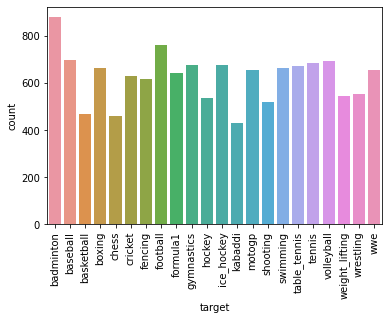

In [7]:
ax = sns.countplot(
    data_df['target'],
    
)
ax.set_xticklabels(labels.values(), rotation=90);

In [8]:
class SportsImageDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.root_dir = root_dir
        
    def __len__(self):
        return len(self.df)    
    
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_id, img_label = row['image_path'], row['target']
        img_fname = self.root_dir + "/" + img_id.split('/')[-2] + "/" + img_id.split('/')[-1]
        img = Image.open(img_fname)
        if self.transform:
            img = self.transform(img)
        return img, int(img_label)

In [9]:
transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.RandomCrop(256), 
        transforms.ToTensor()
    ]
)
dataset = SportsImageDataset(DATA_CSV, DATA_DIR, transform=transform)

In [10]:
np.random.RandomState(23)

RandomState(MT19937) at 0x7FD701085D10

In [11]:
def show_sample(img, target, prediction= False, invert=True):
    print(img.shape)
    if invert:
        plt.imshow(1 - img.permute((1, 2, 0)))
    else:
        plt.imshow(img.permute(1, 2, 0))
    print('Label (numeric):', target)
    if not prediction:
        print('Label:', labels[target])

torch.Size([3, 256, 256])
Label (numeric): 5
Label: cricket


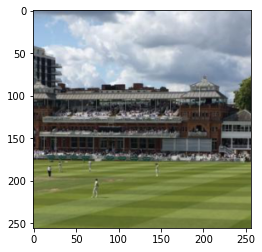

In [12]:
show_sample(*dataset[13799], invert=False)

In [13]:
torch.manual_seed(23)

In [14]:
val_pct = 0.1
val_size = int(val_pct * len(dataset))
test_pct = 0.1
test_size = int(test_pct * len(dataset))
train_size = len(dataset) - val_size - test_size

In [15]:
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds), len(test_ds)

(11040, 1380, 1380)

In [16]:
batch_size = 32

In [17]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [18]:
def show_batch(dl, invert=True):
    for images, labels in dl:
        print('images.shape:', images.shape)
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        data = 1-images if invert else images
        ax.imshow(make_grid(data, nrow=16).permute(1, 2, 0))
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape: torch.Size([32, 3, 256, 256])


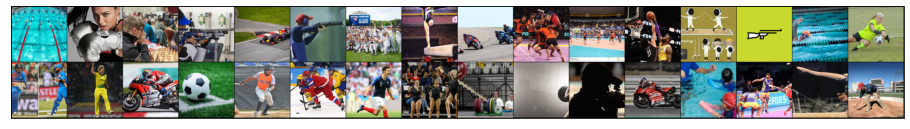

In [19]:
show_batch(train_loader, False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape: torch.Size([64, 3, 256, 256])


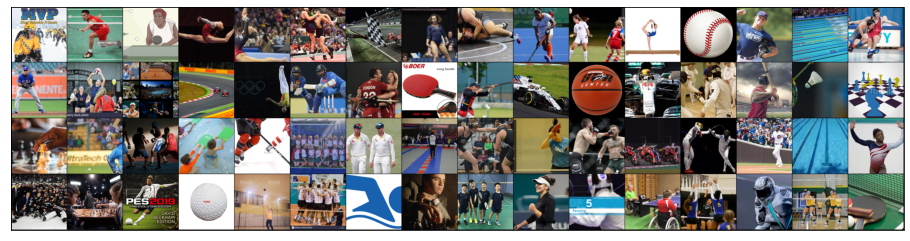

In [20]:
show_batch(val_loader, False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape: torch.Size([64, 3, 256, 256])


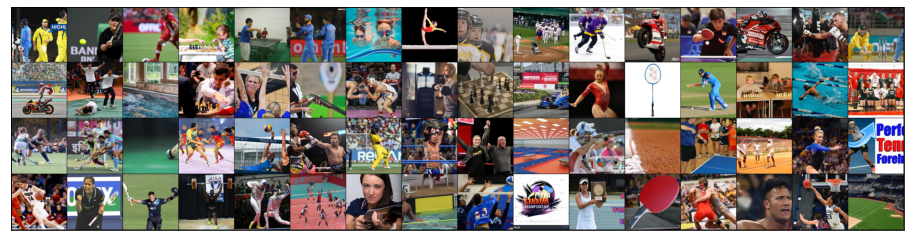

In [21]:
show_batch(test_loader, False)

In [22]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [23]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [24]:
class SportsImageLinearModel(ImageClassificationBase):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.linear1 = nn.Linear(input_size, 1024)
        self.linear2 = nn.Linear(1024, 512)
        self.linear3 = nn.Linear(512, 256)
        self.linear4 = nn.Linear(256, 32)
        self.linear5 = nn.Linear(32, output_size)
        
    def forward(self, xb):
        # Flatten images into vectors
        out = xb.view(xb.size(0), -1)
        out = self.linear1(out)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out = self.linear3(out)
        out = F.relu(out)
        out = self.linear4(out)
        out = F.relu(out)
        out = self.linear5(out)
        return out

In [25]:
class SportsImageLinearModel(ImageClassificationBase):
    def __init__(self, output_size):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, output_size)
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))
    
    def freeze(self):
        # to freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
        
        # only train the last layer
        for param in self.network.fc.parameters():
            param.require_grad = True
            
    def unfreeze(self):
        for param in self.network.parameters():
            param.require_grad = True

In [26]:
#input_size = 49152
output_size = 22

In [27]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [28]:
device = get_default_device()
device

device(type='cuda')

In [29]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
model = to_device(SportsImageLinearModel(output_size), device)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [30]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam):   #RMSprop or SGD or Adam
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [32]:
from tqdm import tqdm
history = [evaluate(model, val_loader)]  #prelim eval if we just did one epoch
history

#now it's actually running-- will take a while
history += fit(50, 0.001, model, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  0%|          | 0/345 [00:00<?, ?it/s]

Epoch [0], train_loss: 2.6323, val_loss: 2.6280, val_acc: 0.3689


  0%|          | 0/345 [00:00<?, ?it/s]

Epoch [1], train_loss: 2.5337, val_loss: 2.5546, val_acc: 0.4456


  0%|          | 0/345 [00:00<?, ?it/s]

Epoch [2], train_loss: 2.4828, val_loss: 2.4978, val_acc: 0.5395


  0%|          | 0/345 [00:00<?, ?it/s]

Epoch [3], train_loss: 2.4500, val_loss: 2.4908, val_acc: 0.5022


  0%|          | 0/345 [00:00<?, ?it/s]

Epoch [4], train_loss: 2.4225, val_loss: 2.5004, val_acc: 0.4989


  0%|          | 0/345 [00:00<?, ?it/s]

Epoch [5], train_loss: 2.4059, val_loss: 2.4607, val_acc: 0.5784


  0%|          | 0/345 [00:00<?, ?it/s]

Epoch [6], train_loss: 2.3885, val_loss: 2.4380, val_acc: 0.5903


  0%|          | 0/345 [00:00<?, ?it/s]

Epoch [7], train_loss: 2.3769, val_loss: 2.4126, val_acc: 0.6301


  0%|          | 0/345 [00:00<?, ?it/s]

Epoch [8], train_loss: 2.3580, val_loss: 2.4016, val_acc: 0.6674


  0%|          | 0/345 [00:00<?, ?it/s]

Epoch [9], train_loss: 2.3512, val_loss: 2.3974, val_acc: 0.6420


  0%|          | 0/345 [00:00<?, ?it/s]

Epoch [10], train_loss: 2.3342, val_loss: 2.3820, val_acc: 0.6756


  0%|          | 0/345 [00:00<?, ?it/s]

Epoch [11], train_loss: 2.3276, val_loss: 2.3862, val_acc: 0.6541


  0%|          | 0/345 [00:00<?, ?it/s]

Epoch [12], train_loss: 2.3228, val_loss: 2.3847, val_acc: 0.6824


  0%|          | 0/345 [00:00<?, ?it/s]

Epoch [13], train_loss: 2.3080, val_loss: 2.3819, val_acc: 0.6930


  0%|          | 0/345 [00:00<?, ?it/s]

Epoch [14], train_loss: 2.3039, val_loss: 2.3968, val_acc: 0.6615


  0%|          | 0/345 [00:00<?, ?it/s]

Epoch [15], train_loss: 2.2986, val_loss: 2.3842, val_acc: 0.6743


  0%|          | 0/345 [00:00<?, ?it/s]

Epoch [16], train_loss: 2.2892, val_loss: 2.3679, val_acc: 0.6748


  0%|          | 0/345 [00:00<?, ?it/s]

Epoch [17], train_loss: 2.2812, val_loss: 2.3775, val_acc: 0.6929


  0%|          | 0/345 [00:00<?, ?it/s]

Epoch [18], train_loss: 2.2829, val_loss: 2.3884, val_acc: 0.6839


  0%|          | 0/345 [00:00<?, ?it/s]

Epoch [19], train_loss: 2.2742, val_loss: 2.3816, val_acc: 0.6830


  0%|          | 0/345 [00:00<?, ?it/s]

Epoch [20], train_loss: 2.2704, val_loss: 2.3620, val_acc: 0.7008


  0%|          | 0/345 [00:00<?, ?it/s]

Epoch [21], train_loss: 2.2614, val_loss: 2.3654, val_acc: 0.7251


  0%|          | 0/345 [00:00<?, ?it/s]

Epoch [22], train_loss: 2.2620, val_loss: 2.3529, val_acc: 0.7072


  0%|          | 0/345 [00:00<?, ?it/s]

Epoch [23], train_loss: 2.2562, val_loss: 2.3805, val_acc: 0.6850


  0%|          | 0/345 [00:00<?, ?it/s]

Epoch [24], train_loss: 2.2527, val_loss: 2.3530, val_acc: 0.7124


  0%|          | 0/345 [00:00<?, ?it/s]

Epoch [25], train_loss: 2.2566, val_loss: 2.3561, val_acc: 0.7275


  0%|          | 0/345 [00:00<?, ?it/s]

Epoch [26], train_loss: 2.2504, val_loss: 2.3514, val_acc: 0.7326


  0%|          | 0/345 [00:00<?, ?it/s]

Epoch [27], train_loss: 2.2486, val_loss: 2.3442, val_acc: 0.7297


  0%|          | 0/345 [00:00<?, ?it/s]

Epoch [28], train_loss: 2.2459, val_loss: 2.3417, val_acc: 0.7453


  0%|          | 0/345 [00:00<?, ?it/s]

Epoch [29], train_loss: 2.2378, val_loss: 2.3670, val_acc: 0.7175


  0%|          | 0/345 [00:00<?, ?it/s]

Epoch [30], train_loss: 2.2337, val_loss: 2.3503, val_acc: 0.7118


  0%|          | 0/345 [00:00<?, ?it/s]

Epoch [31], train_loss: 2.2393, val_loss: 2.3689, val_acc: 0.7240


  0%|          | 0/345 [00:00<?, ?it/s]

Epoch [32], train_loss: 2.2340, val_loss: 2.3670, val_acc: 0.7287


  0%|          | 0/345 [00:00<?, ?it/s]

Epoch [33], train_loss: 2.2313, val_loss: 2.3483, val_acc: 0.7431


  0%|          | 0/345 [00:00<?, ?it/s]

Epoch [34], train_loss: 2.2316, val_loss: 2.3726, val_acc: 0.7186


  0%|          | 0/345 [00:00<?, ?it/s]

Epoch [35], train_loss: 2.2262, val_loss: 2.3599, val_acc: 0.7473


  0%|          | 0/345 [00:00<?, ?it/s]

Epoch [36], train_loss: 2.2275, val_loss: 2.3658, val_acc: 0.7217


  0%|          | 0/345 [00:00<?, ?it/s]

Epoch [37], train_loss: 2.2270, val_loss: 2.3430, val_acc: 0.7382


  0%|          | 0/345 [00:00<?, ?it/s]

Epoch [38], train_loss: 2.2272, val_loss: 2.3480, val_acc: 0.7261


  0%|          | 0/345 [00:00<?, ?it/s]

Epoch [39], train_loss: 2.2203, val_loss: 2.3477, val_acc: 0.7545


  0%|          | 0/345 [00:00<?, ?it/s]

Epoch [40], train_loss: 2.2210, val_loss: 2.3831, val_acc: 0.6996


  0%|          | 0/345 [00:00<?, ?it/s]

Epoch [41], train_loss: 2.2200, val_loss: 2.3663, val_acc: 0.7243


  0%|          | 0/345 [00:00<?, ?it/s]

Epoch [42], train_loss: 2.2150, val_loss: 2.3346, val_acc: 0.7715


  0%|          | 0/345 [00:00<?, ?it/s]

Epoch [43], train_loss: 2.2159, val_loss: 2.3326, val_acc: 0.7608


  0%|          | 0/345 [00:00<?, ?it/s]

Epoch [44], train_loss: 2.2192, val_loss: 2.3367, val_acc: 0.7543


  0%|          | 0/345 [00:00<?, ?it/s]

Epoch [45], train_loss: 2.2142, val_loss: 2.3553, val_acc: 0.7442


  0%|          | 0/345 [00:00<?, ?it/s]

Epoch [46], train_loss: 2.2160, val_loss: 2.3538, val_acc: 0.7460


  0%|          | 0/345 [00:00<?, ?it/s]

Epoch [47], train_loss: 2.2147, val_loss: 2.3378, val_acc: 0.7561


  0%|          | 0/345 [00:00<?, ?it/s]

Epoch [48], train_loss: 2.2113, val_loss: 2.3371, val_acc: 0.7745


100%|██████████| 345/345 [01:16<00:00,  4.51it/s]


Epoch [49], train_loss: 2.2097, val_loss: 2.3487, val_acc: 0.7562


In [33]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

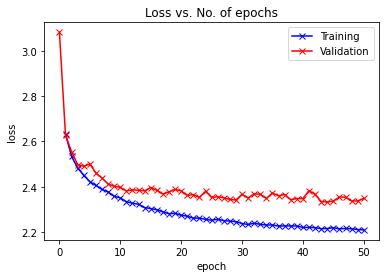

In [34]:
plot_losses(history)

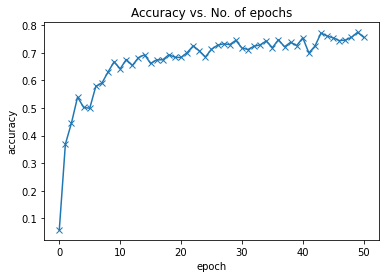

In [35]:
plot_accuracies(history)